In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier , export_graphviz
from sklearn.model_selection import train_test_split # Import train_test_split function
import os
import s3fs
import pyarrow.parquet as pq

pd.set_option('max_rows',None)
pd.set_option('max_columns',None)

# os.chdir('/../mnt')

def train_tree(mdt, y_var, params_dict):
    """
    Trains the tree to produce the profile
    :param params_dict:
    :return:
    """
    # Parameters
    predictive_vars = params_dict['predictive_cols']
    min_percent_leaf = params_dict['min_percent_leaf']

    mdt = mdt[predictive_vars]

    reg_tree = DecisionTreeClassifier(criterion="entropy", max_depth=3,min_samples_leaf=int(mdt.shape[0] * min_percent_leaf))

    reg_tree.fit(mdt, y_var)

    return reg_tree


def produce_dot_file(trained_tree, file_name):
    full_path = params_dict['output_path'] + file_name
    export_graphviz(trained_tree, feature_names=params_dict['predictive_cols'],
                    out_file=full_path,
                    filled=True, proportion=True,
                    rounded=True)


def main(mdt, y_var):
    name = 'tree_'+params_dict['segment_name']+'_V0.dot'
    my_tree = train_tree(mdt, y_var, params_dict)
    produce_dot_file(my_tree, name)
    print('Tree produced')
    return my_tree



In [2]:
# Definir parámetros
params_dict = {'min_percent_leaf': 0.05,
               'input_path':'s3://adl-refined-dev-popular/parquet/TC_adquisicion/total_tdc_perf',
              'output_path':'/mnt/work/CU_adquisicionTC/Notebooks/creacion modelo/resultados_arbolV0/',
              'segment_name':'perfilados'}

In [3]:
fs = s3fs.S3FileSystem()

# Leyendo base
input = params_dict['input_path']
dataset = pq.ParquetDataset(input, filesystem=fs)
table = dataset.read()
mdt = table.to_pandas()

del input, dataset, table

# Definiendo Var Obj'var_final'etivo
y_var = 'var_final'


In [4]:
mdt.shape

(27731, 1260)

In [5]:
mdt.columns

Index(['id_cliente', 'fecha_activo', 'fecha_buro', 'mes_campaña', 'venta',
       '30first_use', 'var_final', 'tipo_campana', 'periodo',
       'acierta_a_financiero',
       ...
       'mora_max_ult6_meses_trad', 'cupo_prom_ult7_meses_trad',
       'util_prom_ult6_meses_trad', 'mora_cierre_ult_mes_trad',
       'cuota_paga_prom_ult3_meses_trad', 'saldo_prom_ult6_meses_trad',
       'cuota_paga_prom_ult7_meses_trad', 'util_prom_ult3_meses_trad',
       'cupo_prom_ult3_meses_trad', 'saldo_prom_ult7_meses_trad'],
      dtype='object', length=1260)

In [6]:
np.random.seed(seed=1234) # Semilla
## Muestra del 50%
#Se generan numeros aleatorios entre 0 y 1
mdt['ran']=np.random.random(size=mdt.shape[0])

#Se seleccion train : 50% 
mdt_v0=mdt[mdt['ran']<=0.5]

# quitando otras variables VO
mdt_v0.drop(columns=['var_final','venta','id_cliente', 'fecha_activo', 'fecha_buro', 'fecha_data', 'fecha_envio',
                     'mes_campaña','tipo_campana', 'periodo','cedulaenc','tipo_cliente','tipo_id','derogatorio',
                    'fecha_real','fecha_mas_antigua_apertura','timestamp','lag_t_6_saldo_tot_tot_SMLV', 
                     'lag_t_1_cuota_tot_LB_SMLV', 'lag_t_6_cuota_tot_LB_SMLV', 'lag_t_6_cuota_tot_tot_SMLV', 
                     'lag_t_1_amortizacion_prom_LB', 'lag_t_6_amortizacion_prom_LB', 'lag_t_1_amortizacion_prom_tot', 
                     'lag_t_6_amortizacion_prom_tot', 'lag_t_6_saldo_tot_LB_SMLV', 'lag_t_1_saldo_tot_tot_SMLV', 
                     'lag_t_1_cuota_tot_tot_SMLV', 'lag_t_6_cupo_tot_LB_SMLV', 'lag_t_1_cupo_tot_tot_SMLV', 'lag_t_6_cupo_tot_tot_SMLV'], inplace = True)



/home/jupyter/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
cat_cols = list(mdt_v0.dtypes[mdt_v0.dtypes=='object'].index)
cat_cols

['ciudad_de_expedicion',
 'genero',
 'peor_califi_trim_1_endeud',
 'peor_calif_trim_2_endeud',
 'rango_aproximado_edad',
 'marca_derogatorio',
 'tdc_altura_maxima_de_mora_was_is',
 'cartera_banca_alt_max_de_mora_was_is',
 'cartera_coope_alt_max_de_mora_was_is',
 'cartera_hipote_alt_max_de_mora_was_is',
 'moramax_mercado_was_is',
 'was_is_LB',
 'was_is_TC',
 'was_is_NV',
 'was_is_CH',
 'was_is_CE',
 'was_is_LE',
 'was_is_ME',
 'was_is_SO',
 'was_is_CC',
 'was_is_TC_X',
 'was_is_TC_T',
 'was_is_tot']

In [8]:
# feature engineering

mdt_v0['ciudad_de_expedicion_cat'] = (mdt_v0['ciudad_de_expedicion'] == 'BOGOTA D.C.').astype('int')
mdt_v0['genero_cat'] = (mdt_v0['genero'] == 'F').astype('int')
mdt_v0['peor_califi_trim_1_endeud_cat'] = (mdt_v0['peor_califi_trim_1_endeud'] == 'mantiene').astype('int')
mdt_v0['peor_calif_trim_2_endeud_cat'] = (mdt_v0['peor_calif_trim_2_endeud'] == 'mantiene').astype('int')
mdt_v0['rango_aproximado_edad_cat'] = (mdt_v0['rango_aproximado_edad'] == 'mantiene').astype('int')
mdt_v0['marca_derogatorio_cat'] = (mdt_v0['marca_derogatorio'] == 'aprobado').astype('int')
mdt_v0['tdc_altura_maxima_de_mora_was_is_cat'] = (mdt_v0['tdc_altura_maxima_de_mora_was_is'] == 'mantiene').astype('int')
mdt_v0['cartera_banca_alt_max_de_mora_was_is_cat'] = (mdt_v0['cartera_banca_alt_max_de_mora_was_is'] == 'mantiene').astype('int')
mdt_v0['cartera_coope_alt_max_de_mora_was_is_cat'] = (mdt_v0['cartera_coope_alt_max_de_mora_was_is'] == 'mantiene').astype('int')
mdt_v0['cartera_hipote_alt_max_de_mora_was_is_cat'] = (mdt_v0['cartera_hipote_alt_max_de_mora_was_is'] == 'mantiene').astype('int')
mdt_v0['moramax_mercado_was_is_cat'] = (mdt_v0['moramax_mercado_was_is'] == 'mantiene').astype('int')
mdt_v0['was_is_LB_cat'] = (mdt_v0['was_is_LB'] == 'mantiene').astype('int')
mdt_v0['was_is_TC_cat'] = (mdt_v0['was_is_TC'] == 'mantiene').astype('int')
mdt_v0['was_is_NV_cat'] = (mdt_v0['was_is_NV'] == 'mantiene').astype('int')
mdt_v0['was_is_CH_cat'] = (mdt_v0['was_is_CH'] == 'mantiene').astype('int')
mdt_v0['was_is_CE_cat'] = (mdt_v0['was_is_CE'] == 'mantiene').astype('int')
mdt_v0['was_is_LE_cat'] = (mdt_v0['was_is_LE'] == 'mantiene').astype('int')
mdt_v0['was_is_ME_cat'] = (mdt_v0['was_is_ME'] == 'mantiene').astype('int')
mdt_v0['was_is_SO_cat'] = (mdt_v0['was_is_SO'] == 'mantiene').astype('int')
mdt_v0['was_is_CC_cat'] = (mdt_v0['was_is_CC'] == 'mantiene').astype('int')
mdt_v0['was_is_TC_X_cat'] = (mdt_v0['was_is_TC_X'] == 'mantiene').astype('int')
mdt_v0['was_is_TC_T_cat'] = (mdt_v0['was_is_TC_T'] == 'mantiene').astype('int')
mdt_v0['was_is_tot_cat'] = (mdt_v0['was_is_tot'] == 'mantiene').astype('int')


/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [9]:
mdt_v0.drop(columns=cat_cols, inplace = True)

In [10]:
np.random.seed(seed=1234) # Semilla

#Se generan numeros aleatorios entre 0 y 1
mdt_v0['ran2']=np.random.random(size=mdt_v0.shape[0])

#Se seleccion train : 50% 
mdt_train=mdt_v0[mdt_v0['ran2']<=0.8]
mdt_test=mdt_v0[mdt_v0['ran2']>0.8]

###
y = mdt_train['30first_use']
y_test = mdt_test['30first_use']

mdt_train.drop(columns=['30first_use','ran','ran2'],inplace=True)
mdt_test.drop(columns=['30first_use','ran','ran2'],inplace=True)

/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [11]:
cols_modelo = mdt_train.columns
params_dict['predictive_cols'] = cols_modelo

In [12]:
np.random.seed(seed=1234) # Semilla
# Split dataset into training set and test set
X_train, X_val, y_train, y_val = train_test_split(mdt_train, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [13]:
y_train.value_counts(normalize=True)

0    0.998455
1    0.001545
Name: 30first_use, dtype: float64

### Modelo V0 1200 variables

In [14]:
import shap
import scikitplot as skplt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#Se ajusta el modelo con las mejores variables best_20_v3
#'multi:softmax'
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', 
                              seed = 1,  
                              max_depth = 3, 
                              colsample_bytree = 0.8,
                              learning_rate = 0.1, 
                              n_estimators = 1000, min_child_weight = 3)

xgb_model.fit(X_train, y_train, 
              eval_set = [(X_train, y_train), (X_val, y_val)],
              early_stopping_rounds=300)

[0]	validation_0-error:0.001545	validation_1-error:0.000601
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 300 rounds.
[1]	validation_0-error:0.001545	validation_1-error:0.000601
[2]	validation_0-error:0.001545	validation_1-error:0.000601
[3]	validation_0-error:0.001545	validation_1-error:0.000601
[4]	validation_0-error:0.001545	validation_1-error:0.000601
[5]	validation_0-error:0.001545	validation_1-error:0.000601
[6]	validation_0-error:0.001545	validation_1-error:0.000601
[7]	validation_0-error:0.001545	validation_1-error:0.000601
[8]	validation_0-error:0.001545	validation_1-error:0.000601
[9]	validation_0-error:0.001545	validation_1-error:0.000601
[10]	validation_0-error:0.001545	validation_1-error:0.000601
[11]	validation_0-error:0.001545	validation_1-error:0.000601
[12]	validation_0-error:0.001545	validation_1-error:0.000601
[13]	validation_0-error:0.001545	validation_1-error:0.0

[132]	validation_0-error:0.001545	validation_1-error:0.000601
[133]	validation_0-error:0.001545	validation_1-error:0.000601
[134]	validation_0-error:0.001545	validation_1-error:0.000601
[135]	validation_0-error:0.001545	validation_1-error:0.000601
[136]	validation_0-error:0.001545	validation_1-error:0.000601
[137]	validation_0-error:0.001545	validation_1-error:0.000601
[138]	validation_0-error:0.001545	validation_1-error:0.000601
[139]	validation_0-error:0.001545	validation_1-error:0.000601
[140]	validation_0-error:0.001545	validation_1-error:0.000601
[141]	validation_0-error:0.001545	validation_1-error:0.000601
[142]	validation_0-error:0.001545	validation_1-error:0.000601
[143]	validation_0-error:0.001545	validation_1-error:0.000601
[144]	validation_0-error:0.001545	validation_1-error:0.000601
[145]	validation_0-error:0.001545	validation_1-error:0.000601
[146]	validation_0-error:0.001545	validation_1-error:0.000601
[147]	validation_0-error:0.001545	validation_1-error:0.000601
[148]	va

[265]	validation_0-error:0.001545	validation_1-error:0.000601
[266]	validation_0-error:0.001545	validation_1-error:0.000601
[267]	validation_0-error:0.001545	validation_1-error:0.000601
[268]	validation_0-error:0.001545	validation_1-error:0.000601
[269]	validation_0-error:0.001545	validation_1-error:0.000601
[270]	validation_0-error:0.001545	validation_1-error:0.000601
[271]	validation_0-error:0.001545	validation_1-error:0.000601
[272]	validation_0-error:0.001545	validation_1-error:0.000601
[273]	validation_0-error:0.001545	validation_1-error:0.000601
[274]	validation_0-error:0.001545	validation_1-error:0.000601
[275]	validation_0-error:0.001545	validation_1-error:0.000601
[276]	validation_0-error:0.001545	validation_1-error:0.000601
[277]	validation_0-error:0.001545	validation_1-error:0.000601
[278]	validation_0-error:0.001545	validation_1-error:0.000601
[279]	validation_0-error:0.001545	validation_1-error:0.000601
[280]	validation_0-error:0.001545	validation_1-error:0.000601
[281]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=None,
       subsample=1, verbosity=1)

In [15]:
# Predecir probabilidades para data test (20%)

probs_test = xgb_model.predict_proba(mdt_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_test[:, 1])

#AUC
metrics.auc(fpr, tpr)

0.5

In [16]:
#Matriz de confusión
predict_test = (probs_test[:, 1] > 0.045)*1
metrics.confusion_matrix(y_test,predict_test)/len(y_test)

array([[0.        , 0.99745547],
       [0.        , 0.00254453]])

In [17]:
#Accuracy
mdt_test['probs'] = probs_test[:, 1]
metrics.accuracy_score(y_test, predict_test)

/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.002544529262086514

In [18]:
#Recall
metrics.recall_score(y_test, predict_test)

1.0

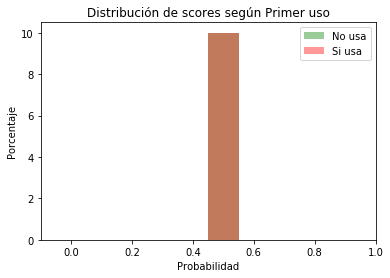

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
%matplotlib inline

# Graficar probabilidades según Fraude/No Fraude observado (real)

subset_si = mdt_test[y_test == 1]

subset_no = mdt_test[y_test == 0]

sns.distplot(subset_no[['probs']], hist = True, norm_hist = True, bins = 10, kde = False, kde_kws = {'linewidth' : 3},
            label = 'No usa', color = 'green')

sns.distplot(subset_si[['probs']], hist = True, norm_hist = True, bins = 10, kde = False, kde_kws = {'linewidth' : 3},
            label = 'Si usa', color = 'red')

plt.legend(prop = {'size' : 10})
plt.title('Distribución de scores según Primer uso')
plt.xlabel('Probabilidad')
plt.ylabel('Porcentaje')
plt.show()

/home/jupyter/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


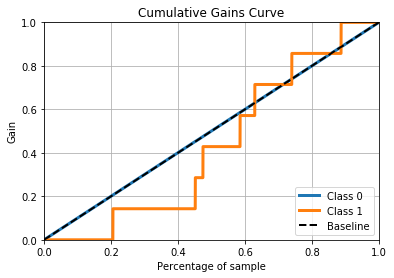

In [20]:
skplt.metrics.plot_cumulative_gain(y_test, probs_test)

In [21]:
#shap_values = shap.TreeExplainer(xgb_model).shap_values(mdt_test)
#shap.summary_plot(shap_values, mdt_test)

In [22]:
#shap.summary_plot(shap_values, test[best_20_v3], plot_type = 'bar')

### Modelo con variables más importantes (top 60)

In [23]:
def train_eval_xgboost(df, features, y, model_num, df_importance):
    
    """
    Función que realiza lo siguiente: 
    1. A partir de Train, realiza un sampling aleatorio 70-30 para Train y Validación
    2. Entrena un modelo XGBoost con la data de Train, usando tanto la data Train como Validación 
        para evaluar (métrica: AUC)
    3. Calcula mean(|SHAP Value|) por variable para base de Train y guarda el valor en df_importance
    4. Calcula auc, accuracy y recall sobre base de Test y guarda los valores en df_metricas, utilizando
    un threshold determinado por el usuario (0.5 por default)
    """
    
    X_train, X_val, y_train, y_val = train_test_split(df[features], y, test_size = .3)
    
    y_train = y_train.astype(int)
    y_val = y_val.astype(int)
    
    print(model_num)
    
    "Entrenar modelo XGBoost"
    
    xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', 
                             max_depth = 3, 
                             colsample_bytree = 0.7,
                             learning_rate = 0.1, 
                             n_estimators = 1000)

    xgb_model.fit(X_train, y_train, 
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  early_stopping_rounds = 500, 
                  verbose = False)
    
    print('Modelo entrenado')
    
    "Calcular y guardar SHAP Values"
    
    shap_values = shap.TreeExplainer(xgb_model).shap_values(df[features])
    shap_feature = np.abs(shap_values).mean(axis = 0)
    
    df_importance['mean_SHAP_'+model_num] = shap_feature
    
    print('SHAP Values guardados')

In [24]:
features_x = cols_modelo
feature_importances = pd.DataFrame({'feature_name' : features_x}, columns = ['feature_name'])

In [25]:
#Se ejecuta 10 veces la función train_eval_xgboost para la base train (80% de la base total de desarrollo) 
# y se calculan los shap values (para las 10 iteraciones) que quedan guardados en el feature_importances

#for i in range(1, 3):
for i in range(1, 11):
    
    model_num = 'model_'+str(i)
    
    train_eval_xgboost(mdt_train, features_x, y, model_num, feature_importances)

model_1
Modelo entrenado
SHAP Values guardados
model_2
Modelo entrenado
SHAP Values guardados
model_3
Modelo entrenado
SHAP Values guardados
model_4
Modelo entrenado
SHAP Values guardados
model_5
Modelo entrenado
SHAP Values guardados
model_6
Modelo entrenado
SHAP Values guardados
model_7
Modelo entrenado
SHAP Values guardados
model_8
Modelo entrenado
SHAP Values guardados
model_9
Modelo entrenado
SHAP Values guardados
model_10
Modelo entrenado
SHAP Values guardados


In [26]:
#A partir de los shap values guardados en feature_importances, se otorga un ranking a las variables y se ordenan según ese ranking

for col in feature_importances.columns[1:]:
    
    feature_importances[col + '_rank'] = feature_importances[col].rank(ascending = False)

In [27]:
# Se seleccionan las 20 mejores variables según ranking anterior
# OJO!!!!!En feature_importances.columns[5:9] se debe poner la posicion de la primera variable _rank hasta la posicion de la ultima variable _rank
principales = []
for col in feature_importances.columns[11:]:
    
    best_60 = [x for x in feature_importances[feature_importances[col] < 100].feature_name.values]
    principales.extend(best_60)

In [28]:
best_60

['acierta_a_financiero', 'numero_obligaciones_activas']

In [29]:
#Se ajusta el modelo con las mejores variables best_20_v3
#'multi:softmax'
xgb_model_v2 = xgb.XGBClassifier(objective = 'binary:logistic', 
                              seed = 1,  
                              max_depth = 3, 
                              colsample_bytree = 0.8,
                              learning_rate = 0.1, 
                              n_estimators = 1000, min_child_weight = 3)

xgb_model_v2.fit(X_train[best_60], y_train, 
              eval_set = [(X_train[best_60], y_train), (X_val[best_60], y_val)],
              early_stopping_rounds=300)

[0]	validation_0-error:0.001545	validation_1-error:0.000601
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 300 rounds.
[1]	validation_0-error:0.001545	validation_1-error:0.000601
[2]	validation_0-error:0.001545	validation_1-error:0.000601
[3]	validation_0-error:0.001545	validation_1-error:0.000601
[4]	validation_0-error:0.001545	validation_1-error:0.000601
[5]	validation_0-error:0.001545	validation_1-error:0.000601
[6]	validation_0-error:0.001545	validation_1-error:0.000601
[7]	validation_0-error:0.001545	validation_1-error:0.000601
[8]	validation_0-error:0.001545	validation_1-error:0.000601
[9]	validation_0-error:0.001545	validation_1-error:0.000601
[10]	validation_0-error:0.001545	validation_1-error:0.000601
[11]	validation_0-error:0.001545	validation_1-error:0.000601
[12]	validation_0-error:0.001545	validation_1-error:0.000601
[13]	validation_0-error:0.001545	validation_1-error:0.0

[132]	validation_0-error:0.001545	validation_1-error:0.000601
[133]	validation_0-error:0.001545	validation_1-error:0.000601
[134]	validation_0-error:0.001545	validation_1-error:0.000601
[135]	validation_0-error:0.001545	validation_1-error:0.000601
[136]	validation_0-error:0.001545	validation_1-error:0.000601
[137]	validation_0-error:0.001545	validation_1-error:0.000601
[138]	validation_0-error:0.001545	validation_1-error:0.000601
[139]	validation_0-error:0.001545	validation_1-error:0.000601
[140]	validation_0-error:0.001545	validation_1-error:0.000601
[141]	validation_0-error:0.001545	validation_1-error:0.000601
[142]	validation_0-error:0.001545	validation_1-error:0.000601
[143]	validation_0-error:0.001545	validation_1-error:0.000601
[144]	validation_0-error:0.001545	validation_1-error:0.000601
[145]	validation_0-error:0.001545	validation_1-error:0.000601
[146]	validation_0-error:0.001545	validation_1-error:0.000601
[147]	validation_0-error:0.001545	validation_1-error:0.000601
[148]	va

[265]	validation_0-error:0.001545	validation_1-error:0.000601
[266]	validation_0-error:0.001545	validation_1-error:0.000601
[267]	validation_0-error:0.001545	validation_1-error:0.000601
[268]	validation_0-error:0.001545	validation_1-error:0.000601
[269]	validation_0-error:0.001545	validation_1-error:0.000601
[270]	validation_0-error:0.001545	validation_1-error:0.000601
[271]	validation_0-error:0.001545	validation_1-error:0.000601
[272]	validation_0-error:0.001545	validation_1-error:0.000601
[273]	validation_0-error:0.001545	validation_1-error:0.000601
[274]	validation_0-error:0.001545	validation_1-error:0.000601
[275]	validation_0-error:0.001545	validation_1-error:0.000601
[276]	validation_0-error:0.001545	validation_1-error:0.000601
[277]	validation_0-error:0.001545	validation_1-error:0.000601
[278]	validation_0-error:0.001545	validation_1-error:0.000601
[279]	validation_0-error:0.001545	validation_1-error:0.000601
[280]	validation_0-error:0.001545	validation_1-error:0.000601
[281]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=None,
       subsample=1, verbosity=1)

In [30]:
# Predecir probabilidades para data test (20%)

probs_test = xgb_model_v2.predict_proba(mdt_test[best_60])

fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_test[:, 1])

#AUC
metrics.auc(fpr, tpr)

0.5

In [31]:
#Matriz de confusión
predict_test = (probs_test[:, 1] > 0.045)*1
metrics.confusion_matrix(y_test,predict_test)


array([[   0, 2744],
       [   0,    7]])

In [32]:
#Accuracy
mdt_test['probs'] = probs_test[:, 1]
metrics.accuracy_score(y_test, predict_test)


/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.002544529262086514

In [33]:
#Recall
metrics.recall_score(y_test, predict_test)

1.0

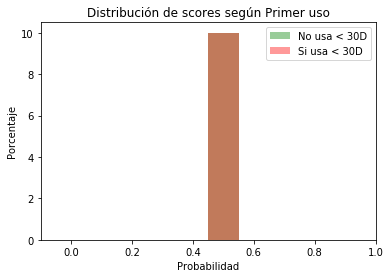

In [34]:
# Graficar probabilidades según Fraude/No Fraude observado (real)

subset_si = mdt_test[y_test == 1]

subset_no = mdt_test[y_test == 0]

sns.distplot(subset_no[['probs']], hist = True, norm_hist = True, bins = 10, kde = False, kde_kws = {'linewidth' : 3},
            label = 'No usa < 30D', color = 'green')

sns.distplot(subset_si[['probs']], hist = True, norm_hist = True, bins = 10, kde = False, kde_kws = {'linewidth' : 3},
            label = 'Si usa < 30D', color = 'red')

plt.legend(prop = {'size' : 10})
plt.title('Distribución de scores según Primer uso')
plt.xlabel('Probabilidad')
plt.ylabel('Porcentaje')
plt.show()

/home/jupyter/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


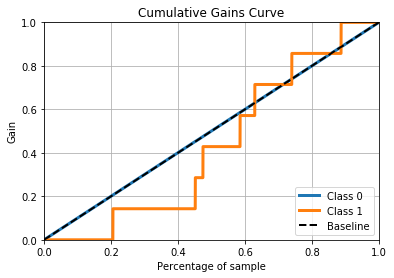

In [35]:
skplt.metrics.plot_cumulative_gain(y_test, probs_test)

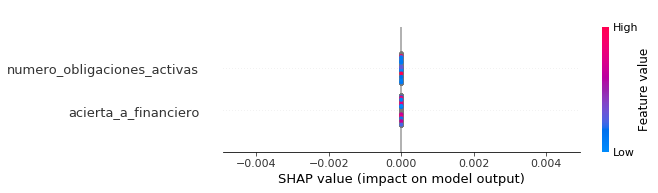

In [36]:
shap_values = shap.TreeExplainer(xgb_model_v2).shap_values(mdt_test[best_60])
shap.summary_plot(shap_values, mdt_test[best_60])

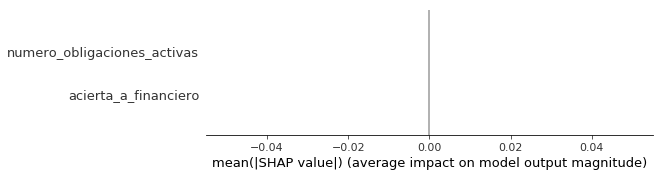

In [37]:
shap.summary_plot(shap_values, mdt_test[best_60], plot_type = 'bar')

In [38]:
## Correr arbol
#main(X_train,y_train)


In [39]:
# Testing tree
my_tree(X_test)

NameError: name 'my_tree' is not defined

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))